In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from keras.models import Model
from keras.applications import Xception # TensorFlow ONLY
from keras.applications.inception_v3 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [43]:
# For predictions using base model
xception = Xception(weights='imagenet') # For classification usage
#xception.summary()

layer = 'block14_sepconv2_act' # last layer = 'block14_sepconv2_act' with features.shape = (1, 10, 10, 2048)

# For feature extraction usage with 3 different ways
#xception_f = Xception(weights='imagenet', include_top=False)
#xception_f = Model(xception.inputs, xception.layers[-3].output) # remove dense layer at the end of model
xception_f = Model(xception.input, xception.get_layer(layer).output)
#xception_f.summary()

In [44]:
layers = [layer.name for layer in xception.layers]
#layers

In [4]:
# Save model summary to text
"""
from contextlib import redirect_stdout
with open('xception_summary_with_top_dense_layer.txt', 'w') as f:
    with redirect_stdout(f):
        xception.summary()
"""

"\nfrom contextlib import redirect_stdout\nwith open('xception_summary_with_top_dense_layer.txt', 'w') as f:\n    with redirect_stdout(f):\n        xception.summary()\n"

### Classification

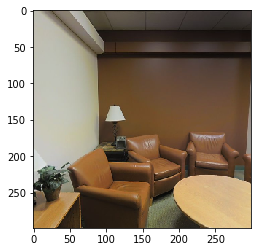

[INFO] classifying image with Xception...
1. home_theater: 45.31%
2. restaurant: 3.53%
3. cinema: 2.00%
4. monitor: 1.51%
5. television: 1.26%


In [49]:
img_rgb = 'C:/Users/ustundag/Desktop/camera_81a9927c6b224f4bb5e6b9fbdcfae9c0_office_3_frame_25_domain_rgb.png'

img = load_img(img_rgb, target_size=(299, 299))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img)
plt.show()

print("[INFO] classifying image with Xception...")
preds = xception.predict(x)
P = decode_predictions(preds)

# loop over the predictions and display the rank-5 predictions
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

### Feature Extraction

(1, 10, 10, 2048)
block14_sepconv2_act


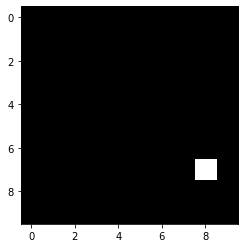

In [50]:
%matplotlib inline
img = load_img(img_rgb, target_size=(299, 299))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = xception_f.predict(x)
print(features.shape)
print(layer)

plt.imshow(features[0, :, :, 100], cmap='gray')
plt.show()

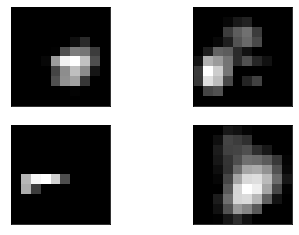

In [51]:
# plot the output from each block
square = 2
for fmap in features:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[:, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()

### PCA + Clustering methods

([<matplotlib.axis.XTick at 0x1e67ecb7a58>,
 <a list of 3 Text xticklabel objects>)

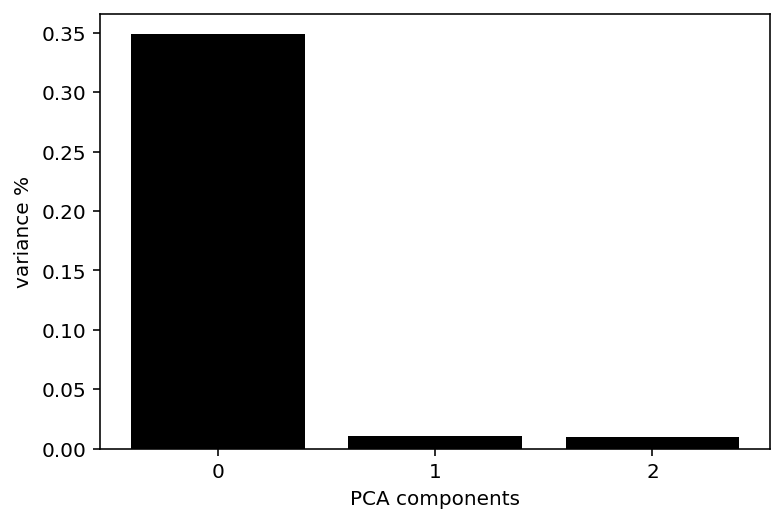

In [52]:
%matplotlib inline
X = features[0].reshape(features.shape[3], features.shape[1]*features.shape[2])

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
%config InlineBackend.figure_format='retina'

# Standardize the data to have a mean of ~0 and a variance of 1
X = StandardScaler().fit_transform(X)
X = normalize(X)

# Create a PCA instance
pca = PCA(n_components=3) # DBSCAN finds only 1 cluster with 3!
PCA_components = pca.fit_transform(X)
# Plot the explained variances
components = range(pca.n_components_)
plt.bar(components, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA components')
plt.ylabel('variance %')
plt.xticks(components)

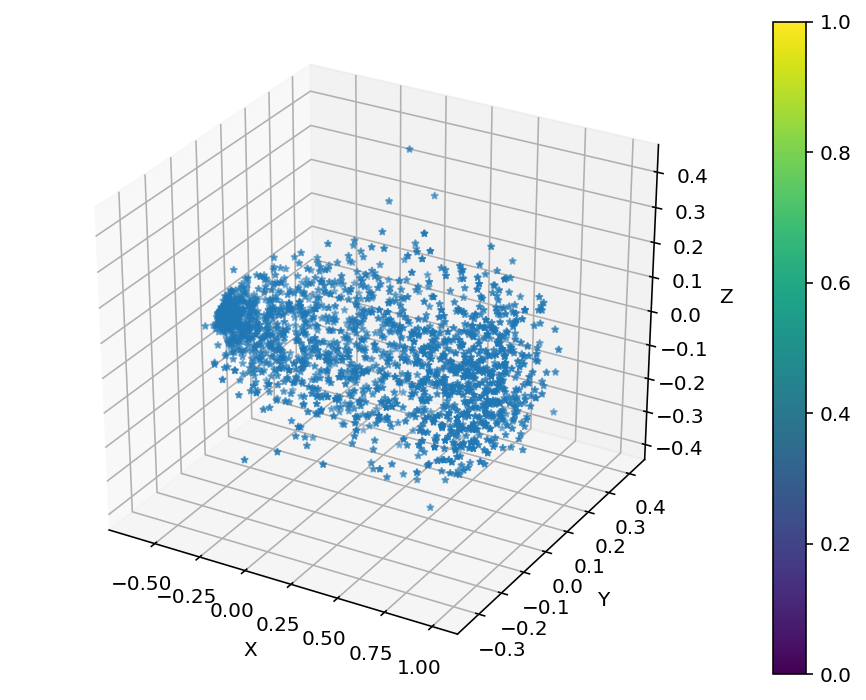

In [53]:
#%matplotlib widget
fig = plt.figure(1, figsize=(8, 6))
ax  = fig.add_subplot(1, 1, 1, projection='3d')
axs = ax.scatter(PCA_components[:,0], PCA_components[:,1], PCA_components[:,2], marker='*', s=10)
fig.colorbar(axs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.dist = 10
plt.show()

In [ ]:
%matplotlib inline
from sklearn.cluster import KMeans

ks = range(1, 5)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to first 10 components
    model.fit(PCA_components)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
#%matplotlib widget
# Apply kmeans and plot 3D
n_clusters = 3
kmeans = KMeans(n_clusters).fit(PCA_components)
labels_kmeans = kmeans.labels_
centers = kmeans.cluster_centers_

fig = plt.figure(1, figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_components[:,0], PCA_components[:,1], PCA_components[:,2], c=labels_kmeans)
ax.scatter(centers[0], centers[1], centers[2], marker='X', c='red', s=100)

fig.colorbar(axs)
ax.set_title("KMeans Clusters: " + str(n_clusters))
ax.dist = 10
plt.show()

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(PCA_components, quantile=0.3, n_samples=13)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(PCA_components)
labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_

fig = plt.figure(1, figsize=(8, 6))
axis = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis
axis.scatter(PCA_components[:,0], PCA_components[:,1], PCA_components[:,2], c=labels_ms, s=50, cmap='viridis')
axis.scatter(cluster_centers[0], cluster_centers[1], cluster_centers[2], marker='X', c='red', s=200)

axis.set_title("Ground-truth Clusters: " + str(len(set(labels_ms))))
plt.show()